In [56]:
import os
import cv2
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Bildpfade und Labels einlesen
image_paths = []
labels = []
base_folder_path = "ImgCaptchaDiffFonts"

for filename in os.listdir(base_folder_path):
    if filename.endswith(".jpg"):
        image_paths.append(os.path.join(base_folder_path, filename))
        labels.append(filename.split('.')[0])

# Bilder Abschnitte teilen
def split_image(image, n_splits=5):
    h, w = image.shape
    split_width = w // n_splits
    sections = [image[:, i*split_width:(i+1)*split_width] for i in range(n_splits)]
    return sections

X = []
y = []
for path, label in zip(image_paths, labels):
    img = preprocess_image(path)
    sections = split_image(img)
    for i, section in enumerate(sections):
        X.append(section.flatten())
        y.append(label[i])  # Einzelne Zeichen als Labels

X = np.array(X)
y = np.array(y)

# Labels numerisch kodieren
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Daten in Trainings- und Testsätze aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


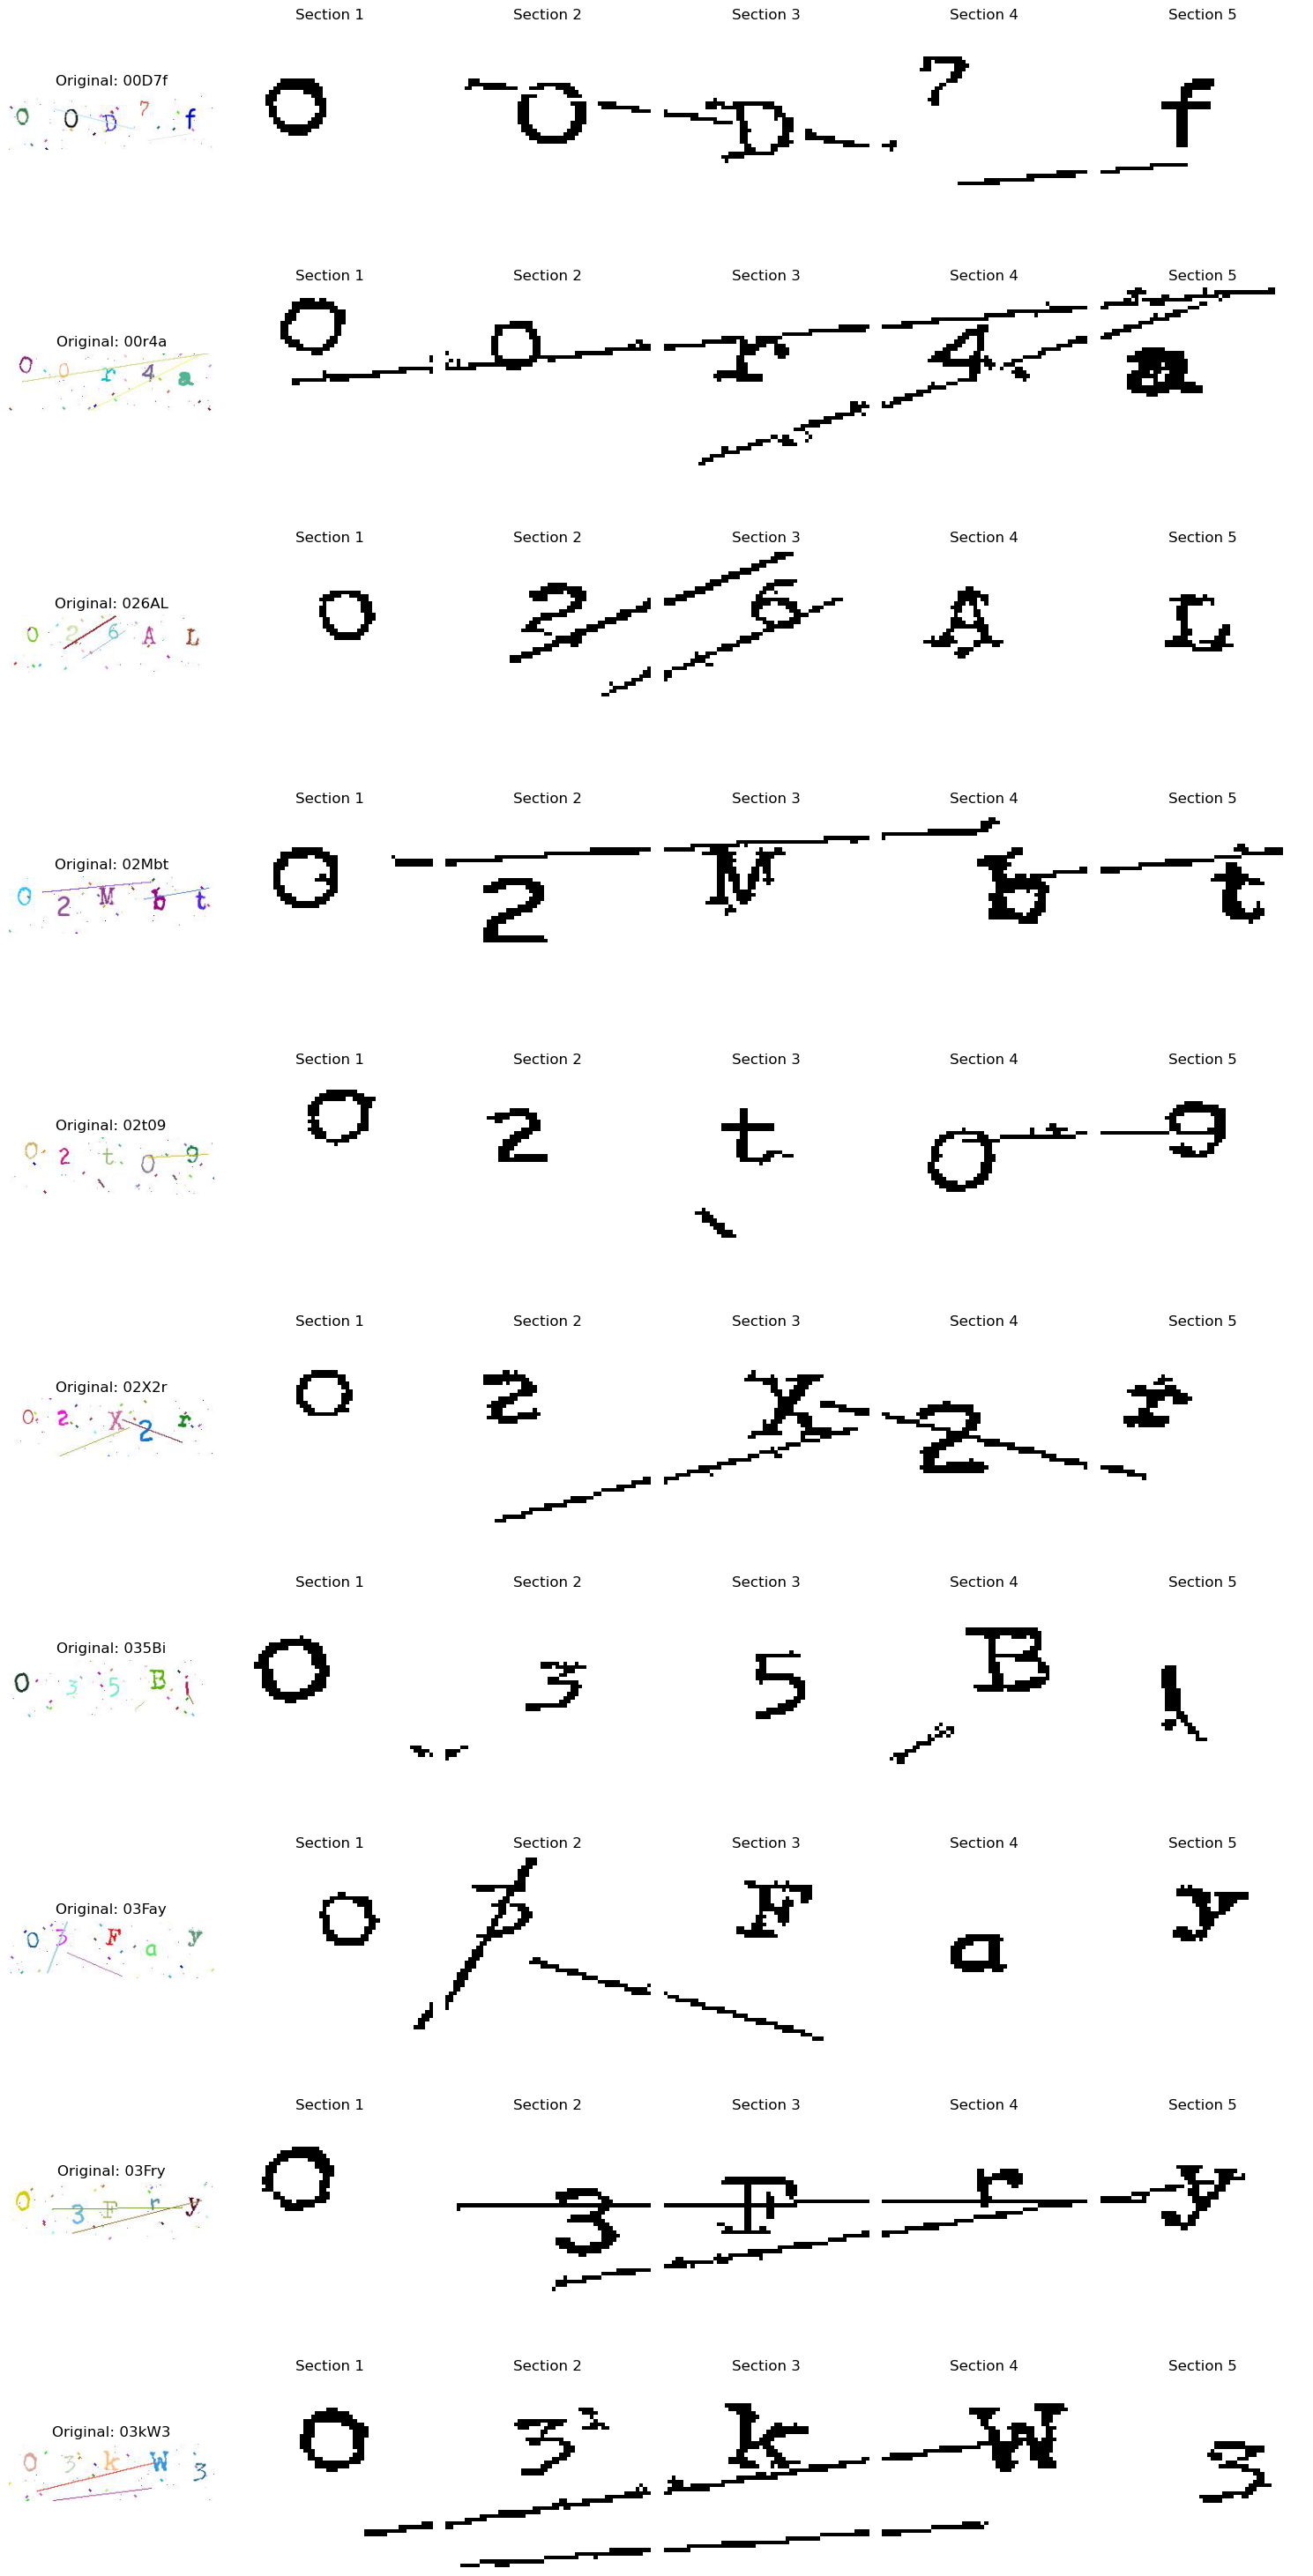

In [57]:
def preprocess_image(image_path, target_size=(270, 50)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    
    # Adaptive Schwellenwert-Binarisierung anwenden
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Alle nicht-weißen Pixel schwarz machen
    img[img < 255] = 0

    # Invertiere die Farben, um schwarze Pixelgruppen zu identifizieren
    inverted = cv2.bitwise_not(img)

    # Verbundene Komponenten finden
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(inverted, connectivity=8)

    # Entferne Pixelgruppen, die kleiner als 20 Pixel sind
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] < 20:
            inverted[labels == i] = 0

    # Invertiere die Farben zurück, sodass schwarze Pixel auf weißem Hintergrund sind
    result = cv2.bitwise_not(inverted)

    return result

# Beispielbilder anzeigen
max_images_per_row = 5
num_images_to_display = min(len(image_paths), 10)

fig, axes = plt.subplots(num_images_to_display, max_images_per_row + 1, figsize=(15, num_images_to_display * 3))

for i in range(num_images_to_display):
    image_path = image_paths[i]
    original_img = plt.imread(image_path)  # Originalbild einlesen
    img = preprocess_image(image_path)  # Bild verarbeiten
    sections = split_image(img)
    
    # Originalbild anzeigen
    axes[i, 0].imshow(original_img, cmap='gray')  # Originalbild anzeigen
    axes[i, 0].set_title(f'Original: {labels[i]}')
    axes[i, 0].axis('off')
    
    # Aufgeteilte Abschnitte anzeigen
    for j, section in enumerate(sections):
        if j < max_images_per_row:  # Begrenze die Anzahl der angezeigten Abschnitte pro Zeile
            axes[i, j+1].imshow(section, cmap='gray')
            axes[i, j+1].set_title(f'Section {j+1}')
            axes[i, j+1].axis('off')

plt.tight_layout()
plt.show()


[flaml.automl.logger: 02-11 14:55:56] {1728} INFO - task = classification
[flaml.automl.logger: 02-11 14:55:56] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 02-11 14:55:56] {1838} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 02-11 14:55:56] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost']
[flaml.automl.logger: 02-11 14:55:56] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 02-11 14:55:58] {2393} INFO - Estimated sufficient time budget=24492s. Estimated necessary time budget=24s.
[flaml.automl.logger: 02-11 14:55:58] {2442} INFO -  at 2.5s,	estimator lgbm's best error=0.9388,	best estimator lgbm's best error=0.9388
[flaml.automl.logger: 02-11 14:55:58] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 02-11 14:56:01] {2442} INFO -  at 5.0s,	estimator lgbm's best error=0.9388,	best estimator lgbm's best error=0.9388
[flaml.automl.logger: 02-11 14:56:01] {2258} INFO - iteration 2, cur

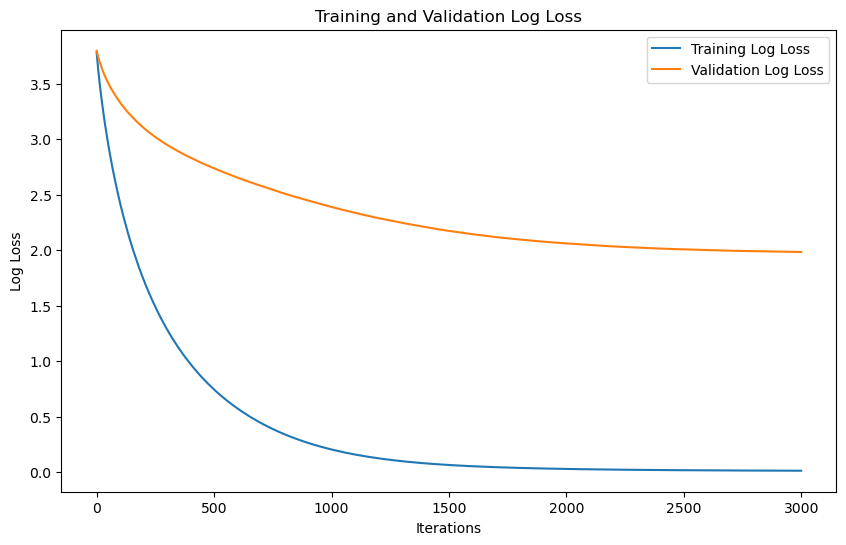

In [58]:
import lightgbm as lgb
from flaml import AutoML
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Bereite die Daten vor
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialisiere AutoML
automl = AutoML()

# Setze die Konfigurationsparameter für AutoML
automl_settings = {
    "time_budget": 1000,  # Erhöhtes Zeitbudget in Sekunden
    "metric": 'accuracy',  # Metrik zur Optimierung
    "task": 'classification',  # Art der Aufgabe
    "log_file_name": 'lightgbm_automl.log',  # Log-Datei
    "estimator_list": ['lgbm', 'rf', 'xgboost'],  # Verwende verschiedene Schätzer
    "n_splits": 5,  # Cross-Validation
    "ensemble": True,  # Ensembling aktivieren
    "verbose": 3  # Verbalisiere die Fortschritte
}

# Trainiere das Modell mit FLAML
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

# Beste Hyperparameter aus FLAML
best_params = automl.best_config

# Anpassung der Hyperparameter für LightGBM zur Vermeidung von Overfitting
params = {
    "objective": "multiclass",
    "num_class": len(np.unique(y_encoded)),
    "metric": "multi_logloss",
    "verbose": -1,
    "learning_rate": 0.01,  # Niedrigere Lernrate
    "num_leaves": best_params.get('num_leaves', 31),
    "min_data_in_leaf": best_params.get('min_data_in_leaf', 20),
    "bagging_fraction": best_params.get('bagging_fraction', 0.8),  # Bootstrap-Sampling
    "bagging_freq": best_params.get('bagging_freq', 1),  # Frequenz für Bagging
    "feature_fraction": best_params.get('feature_fraction', 0.8),
    "lambda_l1": best_params.get('lambda_l1', 0.1),
    "lambda_l2": best_params.get('lambda_l2', 0.1)
}

# Trainings- und Validierungsdaten vorbereiten
train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Modell trainieren mit Callbacks für Early Stopping
evals_result = {}
callbacks = [lgb.early_stopping(stopping_rounds=10), lgb.record_evaluation(evals_result)]

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, validation_data],
    num_boost_round=3000,
    callbacks=callbacks
)

# Vorhersagen auf dem Testsatz
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = [np.argmax(line) for line in y_pred]

# Lernkurve visualisieren
def plot_training_metrics(evals_result):
    plt.figure(figsize=(10, 6))
    plt.plot(evals_result['training']['multi_logloss'], label='Training Log Loss')
    plt.plot(evals_result['valid_1']['multi_logloss'], label='Validation Log Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.title('Training and Validation Log Loss')
    plt.legend()
    plt.show()

plot_training_metrics(evals_result)

# Vorhersagen auf dem Testsatz für Einzelzeichen
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = [np.argmax(line) for line in y_pred]

# Rücktransformation der Vorhersagen in die ursprünglichen Zeichen
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_test_decoded = label_encoder.inverse_transform(y_test)


In [59]:
# Funktion zur Berechnung der Gesamt-Genauigkeit und Ausgabe der Vorhersagen
def calculate_and_display_accuracy(image_paths, labels, X_test_indices, model, num_examples=10, n_splits=5):
    correct_predictions = 0
    total_images = min(num_examples, len(X_test_indices))
    correct_single_chars = 0
    total_single_chars = 0

    true_and_predicted_labels = []

    for idx in X_test_indices[:total_images]:  # Nur die ersten 10 Beispiele
        image_path = image_paths[idx]
        true_label = labels[idx]
        
        img = preprocess_image(image_path)
        sections = split_image(img, n_splits=n_splits)
        
        predicted_label = ''
        
        for j, section in enumerate(sections):
            section_flat = section.flatten().reshape(1, -1)
            prediction = model.predict(section_flat, num_iteration=model.best_iteration)
            predicted_char = label_encoder.inverse_transform([np.argmax(prediction)])
            predicted_label += predicted_char[0]
            
            # Einzelzeichen-Genauigkeit berechnen
            if predicted_char[0] == true_label[j]:
                correct_single_chars += 1
            total_single_chars += 1
        
        true_and_predicted_labels.append((true_label, predicted_label))

        if predicted_label == true_label:
            correct_predictions += 1
    
    overall_accuracy = correct_predictions / total_images
    single_char_accuracy = correct_single_chars / total_single_chars
    
    # Ausgabe der ersten 10 Gesamt-CAPTCHAs mit Labels und Vorhersagen
    for i in range(total_images):
        true_label, predicted_label = true_and_predicted_labels[i]
        print(f"Beispiel {i+1}:")
        print(f"Tatsächliches Label: {true_label}")
        print(f"Vorhergesagtes Label: {predicted_label}")
        print("-" * 30)
    
    print(f"Gesamt-Genauigkeit (mehrzeichen-CAPTCHA) auf dem Testsatz: {overall_accuracy * 100:.2f}%")
    print(f"Einzelzeichen-Genauigkeit auf dem Testsatz: {single_char_accuracy * 100:.2f}%")

# Gesamt-Genauigkeit und Einzelzeichen-Genauigkeit berechnen und anzeigen
_, X_test_indices = train_test_split(range(len(image_paths)), test_size=0.2, random_state=42)
test_image_paths = [image_paths[i] for i in X_test_indices]  # Wählen Sie die Bilder, die im Testdatensatz enthalten sind
test_labels = [labels[i] for i in X_test_indices]  # Entsprechende Labels

calculate_and_display_accuracy(image_paths, labels, X_test_indices, model, num_examples=10)


Beispiel 1:
Tatsächliches Label: 0NNTk
Vorhergesagtes Label: 0NNTk
------------------------------
Beispiel 2:
Tatsächliches Label: HqHhK
Vorhergesagtes Label: BqHhK
------------------------------
Beispiel 3:
Tatsächliches Label: ka2qh
Vorhergesagtes Label: ka2qh
------------------------------
Beispiel 4:
Tatsächliches Label: Yy2MK
Vorhergesagtes Label: Yy2MK
------------------------------
Beispiel 5:
Tatsächliches Label: YmNt6
Vorhergesagtes Label: YmCr4
------------------------------
Beispiel 6:
Tatsächliches Label: XE5fi
Vorhergesagtes Label: XE5fi
------------------------------
Beispiel 7:
Tatsächliches Label: 2D2HX
Vorhergesagtes Label: 2D2HX
------------------------------
Beispiel 8:
Tatsächliches Label: 7576k
Vorhergesagtes Label: 5576K
------------------------------
Beispiel 9:
Tatsächliches Label: WYaHq
Vorhergesagtes Label: WYrHq
------------------------------
Beispiel 10:
Tatsächliches Label: aq3yC
Vorhergesagtes Label: aq3yC
------------------------------
Gesamt-Genauigkeit 